In [1]:
import numpy as np
import pandas as pd 
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="dark")
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation
from sklearn import preprocessing
import cv2
import glob
import os
import warnings as wr

wr.filterwarnings("ignore")



* Data preprocessing
* feature extraction using VGG-16
* training

# Data preparation

In [2]:
train_path=r'../input/pedestrian-detection/Train/Train/JPEGImages'
train_annot=r'../input/pedestrian-detection/Train/Train/Annotations'

test_path=r'../input/pedestrian-detection/Test/Test/JPEGImages'
test_annot=r'../input/pedestrian-detection/Test/Test/Annotations'

val_path=r'../input/pedestrian-detection/Val/Val/JPEGImages'
val_annot=r'../input/pedestrian-detection/Val/Val/Annotations'

In [3]:
def creatingInfoData(Annotpath):
    information={'xmin':[],'ymin':[],'xmax':[],'ymax':[],'ymax':[],'name':[]
                ,'label':[]}

    for file in sorted(glob.glob(str(Annotpath+'/*.xml*'))):
        dat=ET.parse(file)
        for element in dat.iter():    

            if 'object'==element.tag:
                for attribute in list(element):
                    if 'name' in attribute.tag:
                        name = attribute.text                 
                        information['label'] += [name]
                        information['name'] +=[file.split('/')[-1][0:-4]]

                    if 'bndbox'==attribute.tag:
                        for dim in list(attribute):
                            if 'xmin'==dim.tag:
                                xmin=int(round(float(dim.text)))
                                information['xmin']+=[xmin]
                            if 'ymin'==dim.tag:
                                ymin=int(round(float(dim.text)))
                                information['ymin']+=[ymin]
                            if 'xmax'==dim.tag:
                                xmax=int(round(float(dim.text)))
                                information['xmax']+=[xmax]
                            if 'ymax'==dim.tag:
                                ymax=int(round(float(dim.text)))
                                information['ymax']+=[ymax]
                     
    return pd.DataFrame(information)


In [4]:
train_info=creatingInfoData(train_annot)
test_info=creatingInfoData(test_annot)
val_info=creatingInfoData(val_annot)

In [5]:
train_info.head(20)

,xmin,ymin,xmax,ymax,name,label
0,158,44,289,167,image (1),person
1,185,56,287,241,image (10),person
2,2,86,344,374,image (100),person
3,220,95,500,290,image (100),person
4,13,110,213,375,image (101),person
5,149,127,355,375,image (101),person
6,292,61,500,375,image (101),person
7,1,19,335,338,image (102),person
8,261,23,500,338,image (102),person
9,77,46,202,464,image (103),person


> As we expexted there are images has more than one object *** let's see ***

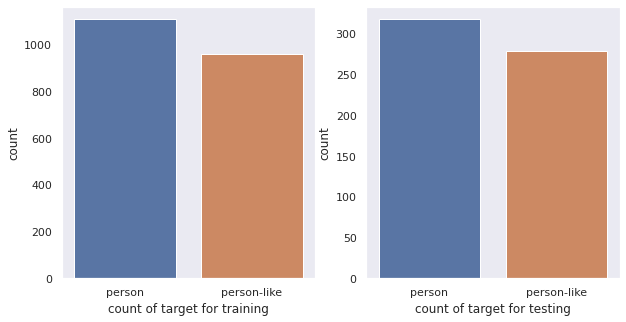

In [6]:
fig=plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
sns.countplot(train_info['label'])
plt.xlabel('count of target for training')

plt.subplot(1,2,2)
sns.countplot(test_info['label'])
plt.xlabel('count of target for testing')

plt.show()


> It 's normally that there are multi objects in specific images so that shape of info 2000 and data 900 

**Let's see an example**

In [7]:
train_info.loc[train_info['name']=='image (101)']

,xmin,ymin,xmax,ymax,name,label
4,13,110,213,375,image (101),person
5,149,127,355,375,image (101),person
6,292,61,500,375,image (101),person


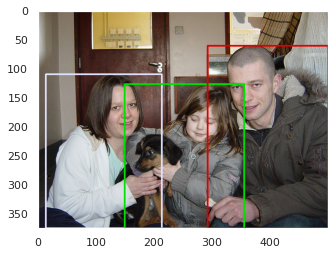

In [8]:
img=cv2.imread(train_path+'/image (101).jpg',cv2.IMREAD_COLOR)
img=cv2.cvtColor(img,cv2.COLOR_BGRA2RGB)

cv2.rectangle(img,(13,110),(213,375),(225,225,255),2)
cv2.rectangle(img,(149,127),(355,375),(0,225,0),2)
cv2.rectangle(img,(292,61),(500,375),(225,0,0),2)

plt.imshow(img)

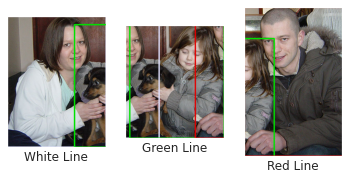

In [9]:
#  y-min, y-max , x-min , x-max
fig=plt.figure()

plt.subplot(1,3,1)
plt.imshow(img[110:375,13:213])
plt.xticks([])
plt.yticks([])
plt.xlabel('White Line')

plt.subplot(1,3,2)
plt.imshow(img[127:375,139:355])
plt.xticks([])
plt.yticks([])
plt.xlabel('Green Line')

plt.subplot(1,3,3)
plt.imshow(img[61:375,292:500])
plt.xticks([])
plt.yticks([])
plt.xlabel('Red Line')

plt.show()

#### So we should splitting objects for the image 

In [10]:
def croppingFromImage(path,Data_information):
    cropped_image=[]
    label=[]
    for i in range(0,len(Data_information)):
        img=cv2.imread(path+'/'+Data_information['name'][i]+'.jpg',cv2.IMREAD_COLOR)
        img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img_=img[Data_information['ymin'][i]:Data_information['ymax'][i],Data_information['xmin'][i]:Data_information['xmax'][i]]
        cropped_image.append(img_)
        
        label.append(Data_information['label'][i])
    return cropped_image , label     

In [11]:
trainImage , trainLabel =croppingFromImage(train_path,train_info)
testImage , testLabel =croppingFromImage(test_path,test_info)

valImage,valLabel=croppingFromImage(val_path,val_info)

In [12]:
print(len(trainImage) == len(trainLabel))
print(len(testImage) == len(testLabel))
print(len(valImage) == len(valLabel))



True
True
True


### Let's see the images

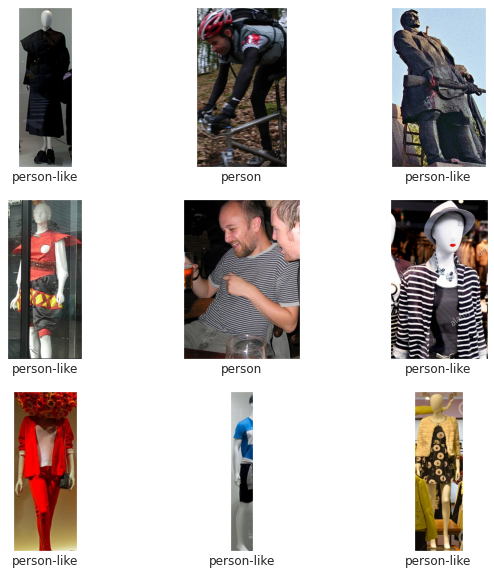

In [13]:
fig=plt.figure(figsize=(10,10))

for i in range (1,10):
    random=np.random.randint(0,len(trainImage))
    plt.subplot(3,3,i)
    plt.imshow(trainImage[random])
    
    plt.xlabel(trainLabel[random])
    plt.xticks([])
    plt.yticks([])

#### The same in testing

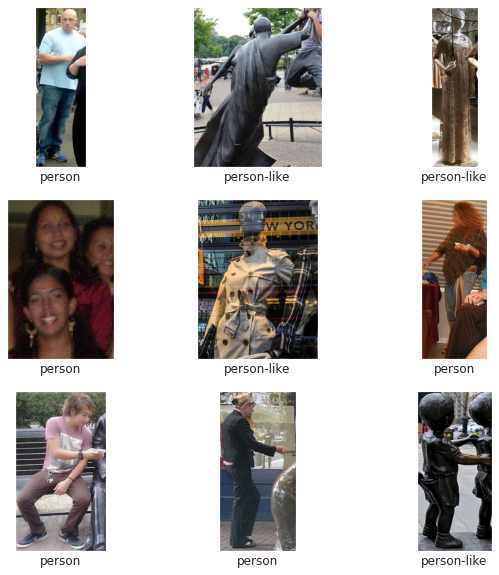

In [14]:
fig=plt.figure(figsize=(10,10))

for i in range (1,10):
    random=np.random.randint(0,len(testImage))
    plt.subplot(3,3,i)
    plt.imshow(testImage[random])
    plt.xlabel(testLabel[random])
    plt.xticks([])
    plt.yticks([])

### As we can see that Data must be reshaped 

In [15]:
trainShapes=[]
testShapes=[]
for i in trainImage :
    trainShapes.append(i.shape)
for i in testImage :
    testShapes.append(i.shape)
   

### Let's see most frequent shapes

In [16]:
pd.Series(trainShapes).value_counts()[:10]

(374, 499, 3)    4
(162, 58, 3)     2
(280, 252, 3)    2
(151, 60, 3)     2
(358, 271, 3)    2
(95, 43, 3)      2
(44, 34, 3)      2
(101, 49, 3)     2
(101, 32, 3)     2
(284, 92, 3)     2
dtype: int64

In [17]:
pd.Series(testShapes).value_counts()[:10]

(85, 52, 3)      2
(128, 58, 3)     2
(128, 47, 3)     2
(120, 37, 3)     2
(171, 74, 3)     2
(105, 81, 3)     2
(506, 449, 3)    1
(225, 128, 3)    1
(180, 94, 3)     1
(187, 85, 3)     1
dtype: int64

### There's observe that cropped objects doesnot has frequent shape and actually this is logical

In [18]:
def resizing(data,size):
    resizing=[]
    for i in data:
        resizing.append(cv2.resize(i,(size,size)))
        
    return resizing   

In [19]:
s=140
X_train,X_test,X_Val=resizing(trainImage,s),resizing(testImage,s),resizing(valImage,s)

In [20]:
labeling=preprocessing.LabelEncoder()
y_train=labeling.fit_transform(trainLabel)
y_test=labeling.fit_transform(testLabel)
y_val=labeling.fit_transform(valLabel)

In [21]:
labeling.classes_

array(['person', 'person-like'], dtype='<U11')

# Feature Extraction

### Here , I will use VGG-16 as a Feature extractor

<img src="https://www.researchgate.net/publication/332412613/figure/fig13/AS:747794327404544@1555299469456/The-VGG-16-architecture-for-the-ImageNet-dataset-26.ppm">

In [22]:
VGG_Model=VGG16(weights='imagenet',include_top=False,input_shape=(s,s,3))

2022-05-11 16:46:01.249718: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-11 16:46:01.331418: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-11 16:46:01.332204: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-11 16:46:01.333310: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

58900480/58889256 [==============================] - 6s 0us/step


In [23]:
for layer in VGG_Model.layers:
    layer.trainable=False



In [24]:
VGG_Model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 140, 140, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 140, 140, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 140, 140, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 70, 70, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 70, 70, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 70, 70, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 35, 35, 128)       0     

In [25]:
### Scaling
X_train,X_test,X_Val=np.asarray(X_train).astype(np.float32),np.asarray(X_test).astype(np.float32),np.asarray(X_Val).astype(np.float32)
X_train,X_test,X_Val=X_train/255.0,X_test/255.0,X_Val/255.0

In [26]:
print(X_train.shape)
print(X_test.shape)

(2066, 140, 140, 3)
(595, 140, 140, 3)


In [27]:
Training=np.concatenate((X_train,X_test))
Training_lbl=np.concatenate((y_train,y_test))

In [28]:
print(Training.shape)
print(Training_lbl.shape)

(2661, 140, 140, 3)
(2661,)


In [29]:
features_extracted=VGG_Model.predict(Training)
features_extracted_test=VGG_Model.predict(X_Val)

2022-05-11 16:46:12.772501: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 625867200 exceeds 10% of free system memory.
2022-05-11 16:46:13.421795: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 625867200 exceeds 10% of free system memory.
2022-05-11 16:46:13.881151: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-05-11 16:46:14.702195: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


In [30]:
flatten=features_extracted.reshape(features_extracted.shape[0],-1)
flatten_test=features_extracted_test.reshape(features_extracted_test.shape[0],-1)

In [31]:
print('train shape before Flatten ',features_extracted.shape)
print('train shape after Flatten ',flatten.shape)
print("="*50)
print('test shape before Flatten ',features_extracted_test.shape)
print('test shape after Flatten ',flatten_test.shape)


train shape before Flatten  (2661, 4, 4, 512)
train shape after Flatten  (2661, 8192)
test shape before Flatten  (333, 4, 4, 512)
test shape after Flatten  (333, 8192)


# Training

In [32]:
model=Sequential()
model.add(Dense(64,input_shape=flatten.shape))
model.add(Activation('relu'))
model.add(Dropout(.7))

model.add(Dense(2))
model.add(Activation('sigmoid'))


In [33]:
model.compile(loss='sparse_categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [34]:
fitting=model.fit(flatten,Training_lbl,batch_size=100,epochs=7,validation_data=(flatten_test,y_val))

Epoch 1/7
27/27 [==============================] - 1s 9ms/step - loss: 0.6633 - accuracy: 0.5994 - val_loss: 0.5210 - val_accuracy: 0.8288
Epoch 2/7
27/27 [==============================] - 0s 4ms/step - loss: 0.5467 - accuracy: 0.6881 - val_loss: 0.4335 - val_accuracy: 0.8348
Epoch 3/7
27/27 [==============================] - 0s 4ms/step - loss: 0.4923 - accuracy: 0.7369 - val_loss: 0.3888 - val_accuracy: 0.8348
Epoch 4/7
27/27 [==============================] - 0s 4ms/step - loss: 0.4608 - accuracy: 0.7426 - val_loss: 0.3607 - val_accuracy: 0.8498
Epoch 5/7
27/27 [==============================] - 0s 4ms/step - loss: 0.4439 - accuracy: 0.7576 - val_loss: 0.3403 - val_accuracy: 0.8498
Epoch 6/7
27/27 [==============================] - 0s 4ms/step - loss: 0.4227 - accuracy: 0.7820 - val_loss: 0.3191 - val_accuracy: 0.8498
Epoch 7/7
27/27 [==============================] - 0s 4ms/step - loss: 0.4140 - accuracy: 0.7760 - val_loss: 0.3596 - val_accuracy: 0.8468


# Evaluation

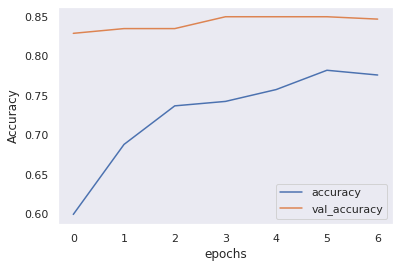

In [35]:
plt.plot(fitting.history['accuracy'])
plt.plot(fitting.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.legend(['accuracy','val_accuracy'],loc='lower right')
plt.show()

In [36]:
pred=model.predict(flatten_test)

In [37]:
def conver(prediction):
    if (prediction[0]>prediction[1]):return 'person'
    else:return 'Not person'

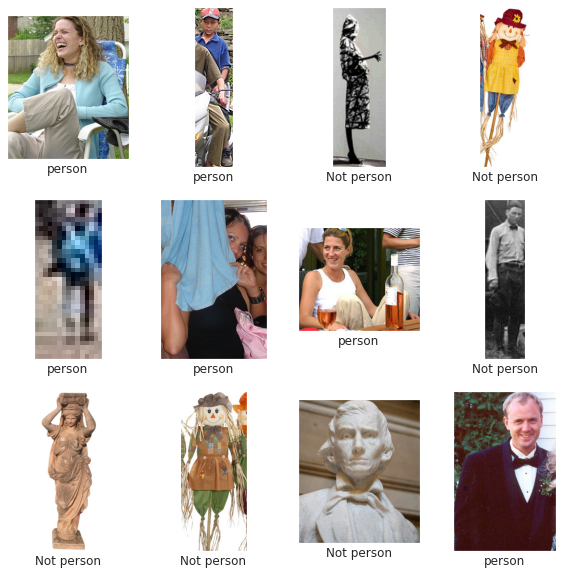

In [38]:
fig=plt.figure(figsize=(10,10))

for i in range (1,13):
    random=np.random.randint(0,len(valImage))
    plt.subplot(3,4,i)
    plt.imshow(valImage[random])
    label=conver(pred[random])
    plt.xlabel(label)
    plt.xticks([])
    plt.yticks([])